In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

import matplotlib.pyplot as plt

In [35]:
df = pd.read_csv("./vaccine_train_set.csv")
df.isnull().sum()

Unnamed: 0    0
tweet         0
label         0
dtype: int64

In [36]:
features = df.drop(['label', 'Unnamed: 0'], axis=1)
X = [ar[0] for ar in features.values]
labels = df['label']
Y = list(labels.values)

In [37]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def customPreprocessor(text: str):
    import re
    
    # remove url's
    trimmedText = re.sub(r'https?://\S+|www\.\S+', '', text).lower()

    # remove @ mentions and numbers
    res = list()
    wait_whitespace = False
    for c in trimmedText:
        if wait_whitespace:
            if c == " ":
                wait_whitespace = False
            continue
        elif re.match("[0-9]", c) or c == "@":
            wait_whitespace = True
            continue            
        res.append(c)
    
    return ''.join(res)

vectorizer = TfidfVectorizer(preprocessor=customPreprocessor, stop_words="english", max_df=0.9, min_df=0.002)
vectorizedData = vectorizer.fit_transform(X)

In [38]:
vectorizer.get_feature_names()

/home/pavlos/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['able',
 'absolutely',
 'access',
 'according',
 'actually',
 'administration',
 'adult',
 'adults',
 'africa',
 'african',
 'age',
 'ago',
 'agree',
 'aids',
 'ain',
 'ainf',
 'alert',
 'allowed',
 'amazing',
 'america',
 'american',
 'americans',
 'amid',
 'amp',
 'analysis',
 'ancestors',
 'announced',
 'anti',
 'ap',
 'apparently',
 'approval',
 'approved',
 'area',
 'aren',
 'arm',
 'article',
 'ask',
 'asked',
 'ass',
 'astrazeneca',
 'autism',
 'autistic',
 'available',
 'average',
 'avoid',
 'away',
 'awesome',
 'babies',
 'baby',
 'bad',
 'bart',
 'based',
 'bc',
 'believe',
 'benefits',
 'best',
 'bet',
 'better',
 'biden',
 'big',
 'biontech',
 'bit',
 'black',
 'blame',
 'blaming',
 'blood',
 'body',
 'boost',
 'booster',
 'boosts',
 'born',
 'boy',
 'brain',
 'breaking',
 'bring',
 'brought',
 'ca',
 'california',
 'called',
 'came',
 'cancer',
 'candidate',
 'care',
 'case',
 'cases',
 'catch',
 'caught',
 'cause',
 'caused',
 'causes',
 'causing',
 'cdc',
 'cdcwhistlebl

In [39]:
# for s in X:
#     vec1 = TfidfVectorizer(preprocessor=removeMentions)
#     vec2 = TfidfVectorizer()
#     ar1 = vec1.fit_transform([s]).toarray()
#     ar2 = vec2.fit_transform([s]).toarray()
#     if (ar1.nbytes > ar2.nbytes):
#         print(s)

In [40]:
#re.sub(r'https?://\S+|www\.\S+', '', "t.co/ODt3RqqJr1 More people have been infected with measles... ")

In [41]:
trainData, testData, trainLabels, testLabels = train_test_split(vectorizedData, Y, train_size=0.8)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=100000)
lr.fit(trainData, trainLabels)


LogisticRegression(max_iter=100000)

In [42]:
predictions = lr.predict(trainData)

In [43]:
targetTestLabels = trainLabels
""" import math
startIndex = math.ceil(len(digitDataSet.data)/2)
targetTestData = digitDataSet.data[startIndex:]
targetTestLabels = digitDataSet.target[startIndex]
predictions = lr.predict(targetTestData) """
""" targetTestLabels = trainLabels
predictions = lr.predict(trainData) """
correct = 0
misses = 0
for i in range(len(predictions)):
    if (predictions[i] == targetTestLabels[i]):
        correct += 1
    else:
        misses += 1
print(f"Correct: {correct}\nMisses: {misses}")
print(f"Correct pct: {round(correct/len(predictions)*100, 2)}%")

Correct: 9438
Misses: 3342
Correct pct: 73.85%


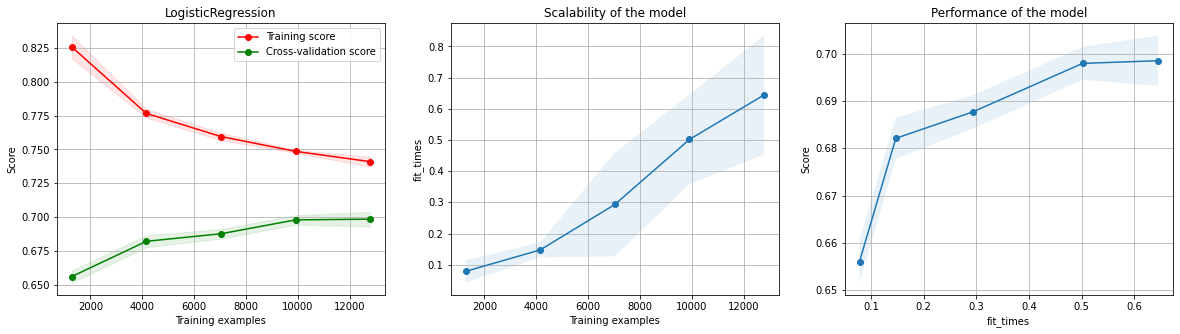

In [44]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

plot_learning_curve(lr, 'LogisticRegression', vectorizedData, Y)
plt.show()